In [1]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tic_env import TictactoeEnv, OptimalPlayer

## Debug taken from QLearning parts

In [ ]:
# (DEBUG) Plotting just one of the curves

plt.figure(figsize=(20, 10))
xs = range(0, epochs, avg_step)

plt.plot(xs, values[2], label=names[2], lw=2)

plt.xlabel('Number of games played', fontsize= 20)
plt.ylabel('Mean reward over {} games'.format(avg_step), fontsize = 20)
plt.title('Evolution of mean reward (every {} games played) of the learner'.format(avg_step), fontsize = 20)
plt.grid()
plt.legend(loc=2)
plt.show()

In [ ]:
# (DEBUG) Avg reward

for elem in values:
    print(np.mean(elem))
    
# ==> so it seems the lower n_star the faster we will learn which does not make intuitive sense

# 2. Q-learning

## 2.1 Learning from experts

In [2]:
def grid_to_string(grid):
    char_rep= {0:'-', 1: 'X',-1:'O'}
    return ''.join([char_rep[x] for x in grid.flatten()])

In [3]:
def action_to_key(action,  state):
    if type(action) is tuple:
        action = action[0]*3 + action[1]
    return (action, grid_to_string(state))

In [4]:
def get_state_best_Q(state, Q_vals, player_rnd):
    
    pot_actions = player_rnd.empty(state)
     # optimal choice wrt policy (eps-greedy)
    best_Q = -math.inf
    best_key = None

    for a in pot_actions:                    
        key = action_to_key(a, state)

        Q_a = Q_vals.get(key, 0)

        if (Q_a > best_Q):
            best_Q = Q_a
            best_key = key
    return best_key, best_Q

In [5]:
### Q-learning algorithm

# game constants
Turns = np.array(['X','O'])
max_game_length = 9
seed = 42
rng = default_rng(seed)
env = TictactoeEnv()
Q_vals = {}

# training constants
epoch = 20000
lr = 0.05
df = 0.99

epsilon_greed = 0.1 #set in [0 ; 1[

# plot variables
avg_reward = []
avg_step = 50 
acc_reward = 0

for ep in range(0, epoch):
    # add mean reward to plot every avg_step epoch
    if ((ep+1)%avg_step==0):
        avg_reward.append(acc_reward/avg_step)
        acc_reward = 0
    
    # init Optimal player (epsilon 0.5) and random player, swap starting role every epoch
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[ep%2])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[(ep+1)%2])
    
    pred_key, pred_rew  = None, None
    
    # game plays up to 9 times
    for j in range(max_game_length):
        
        # the optimal player plays if it its turn
        if env.current_player == player_opt.player:
            move = player_opt.act(env.grid)
        
        # the learner plays if it is their turn
        else:
            # update Q-val if this is not the first time playing
            if(j != 0 and j!=1):
                Q_v = Q_vals.get(pred_key, 0.0)
                Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 
            
            # epsilon chance the player plays randomly
            if(rng.uniform() <= epsilon_greed):
                move = player_rnd.act(env.grid)
            
            # otherwise plays according to the policy
            else:
                key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                move = key[0]
        
        # save current state values before next move is applied
        prev_grid = env.grid.copy()
        round_player = env.current_player
        grid, end, winner = env.step(move, print_grid=False)
        
        # if this is learner's turn, saves additional previous state info 
        if round_player == player_rnd.player:
            pred_key = action_to_key(move, prev_grid)
            pred_rew = env.reward(player_rnd.player)        
        
        # if the game ends, must update the Q-vals before starting a new game
        if end:
            if(round_player != player_rnd.player):
                Q_v = Q_vals.get(pred_key, 0.0)
                # Q_vals[pred_key] = Q_v + lr * (pred_rew - Q_v)   ==> pas checké que mon fix faisait du sens logiquement mais en gros dans la situation actuelle on prenait jamais en compte les moments ou le player perd
                Q_vals[pred_key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            else:
                key = action_to_key(move, prev_grid)
                Q_v = Q_vals.get(key, 0.0)
                Q_vals[key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            
            # reset new game
            acc_reward += env.reward(player_rnd.player)
            env.reset()
            break

In [5]:
### Q-learning algorithm

# game constants
Turns = np.array(['X','O'])
max_game_length = 9
seed = 42
rng = default_rng(seed)
env = TictactoeEnv()
Q_vals = {}

# training constants
epoch = 20000
lr = 0.05
df = 0.99

# epsilon_greed = 0.1 #set in [0 ; 1[
epsilon_greed_max = 0.8
epsilon_greed_min = 0.1
n_star = 20000

# plot variables
avg_reward = []
avg_step = 50 
acc_reward = 0

for ep in range(0, epoch):
    # add mean reward to plot every avg_step epoch
    if ((ep+1)%avg_step==0):
        avg_reward.append(acc_reward/avg_step)
        acc_reward = 0
    
    # init Optimal player (epsilon 0.5) and random player, swap starting role every epoch
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[ep%2])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[(ep+1)%2])
    
    # update epsilon-greed
    epsilon_greed = max(epsilon_greed_min, epsilon_greed_max * (1-((ep+1)/n_star)) )
    
    pred_key, pred_rew  = None, None
    
    # game plays up to 9 times
    for j in range(max_game_length):
        
        # the optimal player plays if it its turn
        if env.current_player == player_opt.player:
            move = player_opt.act(env.grid)
        
        # the learner plays if it is their turn
        else:
            # update Q-val if this is not the first time playing
            if(j != 0 and j!=1):
                Q_v = Q_vals.get(pred_key, 0.0)
                Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 
            
            # epsilon chance the player plays randomly
            if(rng.uniform() <= epsilon_greed):
                move = player_rnd.act(env.grid)
            
            # otherwise plays according to the policy
            else:
                key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                move = key[0]
        
        # save current state values before next move is applied
        prev_grid = env.grid.copy()
        round_player = env.current_player
        grid, end, winner = env.step(move, print_grid=False)
        
        # if this is learner's turn, saves additional previous state info 
        if round_player == player_rnd.player:
            pred_key = action_to_key(move, prev_grid)
            pred_rew = env.reward(player_rnd.player)        
        
        # if the game ends, must update the Q-vals before starting a new game
        if end:
            if(round_player != player_rnd.player):
                Q_v = Q_vals.get(pred_key, 0.0)
                # Q_vals[pred_key] = Q_v + lr * (pred_rew - Q_v)   ==> pas checké que mon fix faisait du sens logiquement mais en gros dans la situation actuelle on prenait jamais en compte les moments ou le player perd
                Q_vals[pred_key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            else:
                key = action_to_key(move, prev_grid)
                Q_v = Q_vals.get(key, 0.0)
                Q_vals[key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            
            # reset new game
            acc_reward += env.reward(player_rnd.player)
            env.reset()
            break

KeyboardInterrupt: 

In [6]:
Q_vals

{(0, '----X----'): 0.4053228162335007,
 (1, 'O-X-X----'): -0.28418530074906245,
 (3, 'OOX-XX---'): -0.13399715640624998,
 (0, '---------'): 0.603027271037127,
 (5, 'X---O----'): 0.053728197805771906,
 (1, 'X---OX-O-'): 0.04732043304506001,
 (2, 'XX--OXOO-'): 0.0975,
 (0, '-------X-'): 0.3126785893415401,
 (1, 'O---X--X-'): 0.45891245727970387,
 (2, 'OO--X--XX'): 0.7364799055342576,
 (1, 'X---O----'): 0.5814797042264118,
 (2, 'XX--O---O'): 0.9999999992256193,
 (3, 'X-O------'): 0.0014693811421908982,
 (1, 'X-OX--O--'): -0.05,
 (0, '--X------'): 0.2266686825453784,
 (6, 'OOX-XX---'): -0.0975,
 (1, 'X--O-----'): 0.7463306990717576,
 (4, 'XXOO-----'): 0.7158484309825646,
 (5, 'XXOOX--O-'): 0.03794224672911937,
 (6, 'XXOOXX-OO'): 0.0,
 (8, '-X-------'): 0.0,
 (2, 'XX------O'): 0.0,
 (3, 'XXO--X--O'): 0.0,
 (4, 'XXOO-XX-O'): 0.0,
 (2, 'XX--O--O-'): 0.9999999993692622,
 (1, 'O-X----X-'): -0.001612100959753711,
 (3, 'OOX-X--X-'): -0.08984736672127733,
 (3, 'XXO-O----'): -0.5073731570803242,
 (

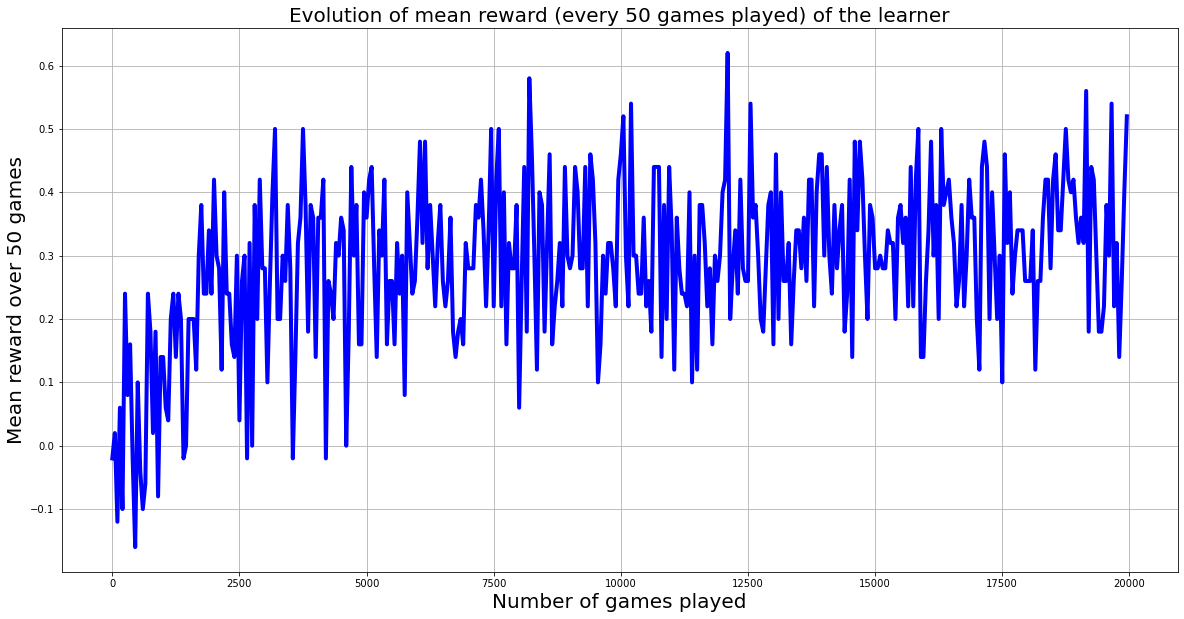

In [7]:
#View evolving mean reward of the learner
plt.figure(figsize=(20, 10))
plt.plot(range(0, 20000, 50), avg_reward, 'b', lw=4)
plt.xlabel('Number of games played', fontsize= 20)
plt.ylabel('Mean reward over {} games'.format(avg_step), fontsize = 20)
plt.title('Evolution of mean reward (every {} games played) of the learner'.format(avg_step), fontsize = 20)
plt.grid()
plt.show()

In [8]:
np.mean(np.array(avg_reward))

0.28769999999999996

In [9]:
np.mean(avg_reward[-50:-1])

0.33061224489795915

In [10]:
neg_Q = filter(lambda x : x<0 , Q_vals.values())
nb_neg = len([x for x in neg_Q])

print(nb_neg)

1714


In [11]:
print(len(Q_vals.values()) - nb_neg)

1944


In [1]:
values = [[1, 5], [45, 2], [1, 5], [1, 8], [1, 5]]

In [ ]:
max([sublist[-1] for sublist in values])